In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# Plotting settings
a_min = 1e-3
a_max = 1
margin = 1.3

# Linear predictions

In [2]:
# from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [3]:
import sympy as sym

import numpy as np
from sympy import symbols, sqrt, lambdify, Function, solve, Derivative, init_printing, exp, pi, sympify, nsimplify, Float, N
init_printing()
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline

In [4]:
plt.style.use('./my_style.py')
import matplotlib.ticker as mticker

from cycler import cycler
import matplotlib.cm     as cm

In [5]:
#Symbolic variables
x, y, mu, k, E_diffa= symbols(r' x, y, \mu, k, E_a')
a= symbols('a', positive=True)
D= Function('D')
E = Function('E')(a)

In [6]:
Om0  = symbols('O_m0')

In [7]:
# h =  0.6774
Om0_val = nsimplify(0.3089)
# Om0 = 0.3

Ol0 = 1- Om0_val
H0_hinvMpc= 1#1/2997.92458

In [8]:
z_ini = 999
z_fin = 0

a_ini = 1/(1+z_ini)
a_fin = 1/(1+z_fin)

z_eval = np.array([ 1.65,1.4,1.2,1])
a_eval = 1/(1+z_eval)

In [9]:
H = H0_hinvMpc*E
H_LCDM = H0_hinvMpc*(Om0_val*a**(-3) + Ol0)**(1/2)
H_LCDM_Or = H0_hinvMpc*sqrt(Om0_val*a**(-3) + Ol0+ 8*10**(-5)*a**(-4))
H_conf = H*a
Om = Om0_val*a**(-3)
Ol = Ol0

# Ben's data

### Background

In [10]:
header_str = 'a,  H_MG,  H_LCDM, H_MG/H_LCDM,  aH dH/da / H0^2 ,  phi , d phi/ dlna'
header = [s.strip(' ')for s in header_str.split(',')]

df_Ben_BG = pd.DataFrame(np.loadtxt('./Data/Background/background_k01_glam.dat'), columns=header).set_index('a')

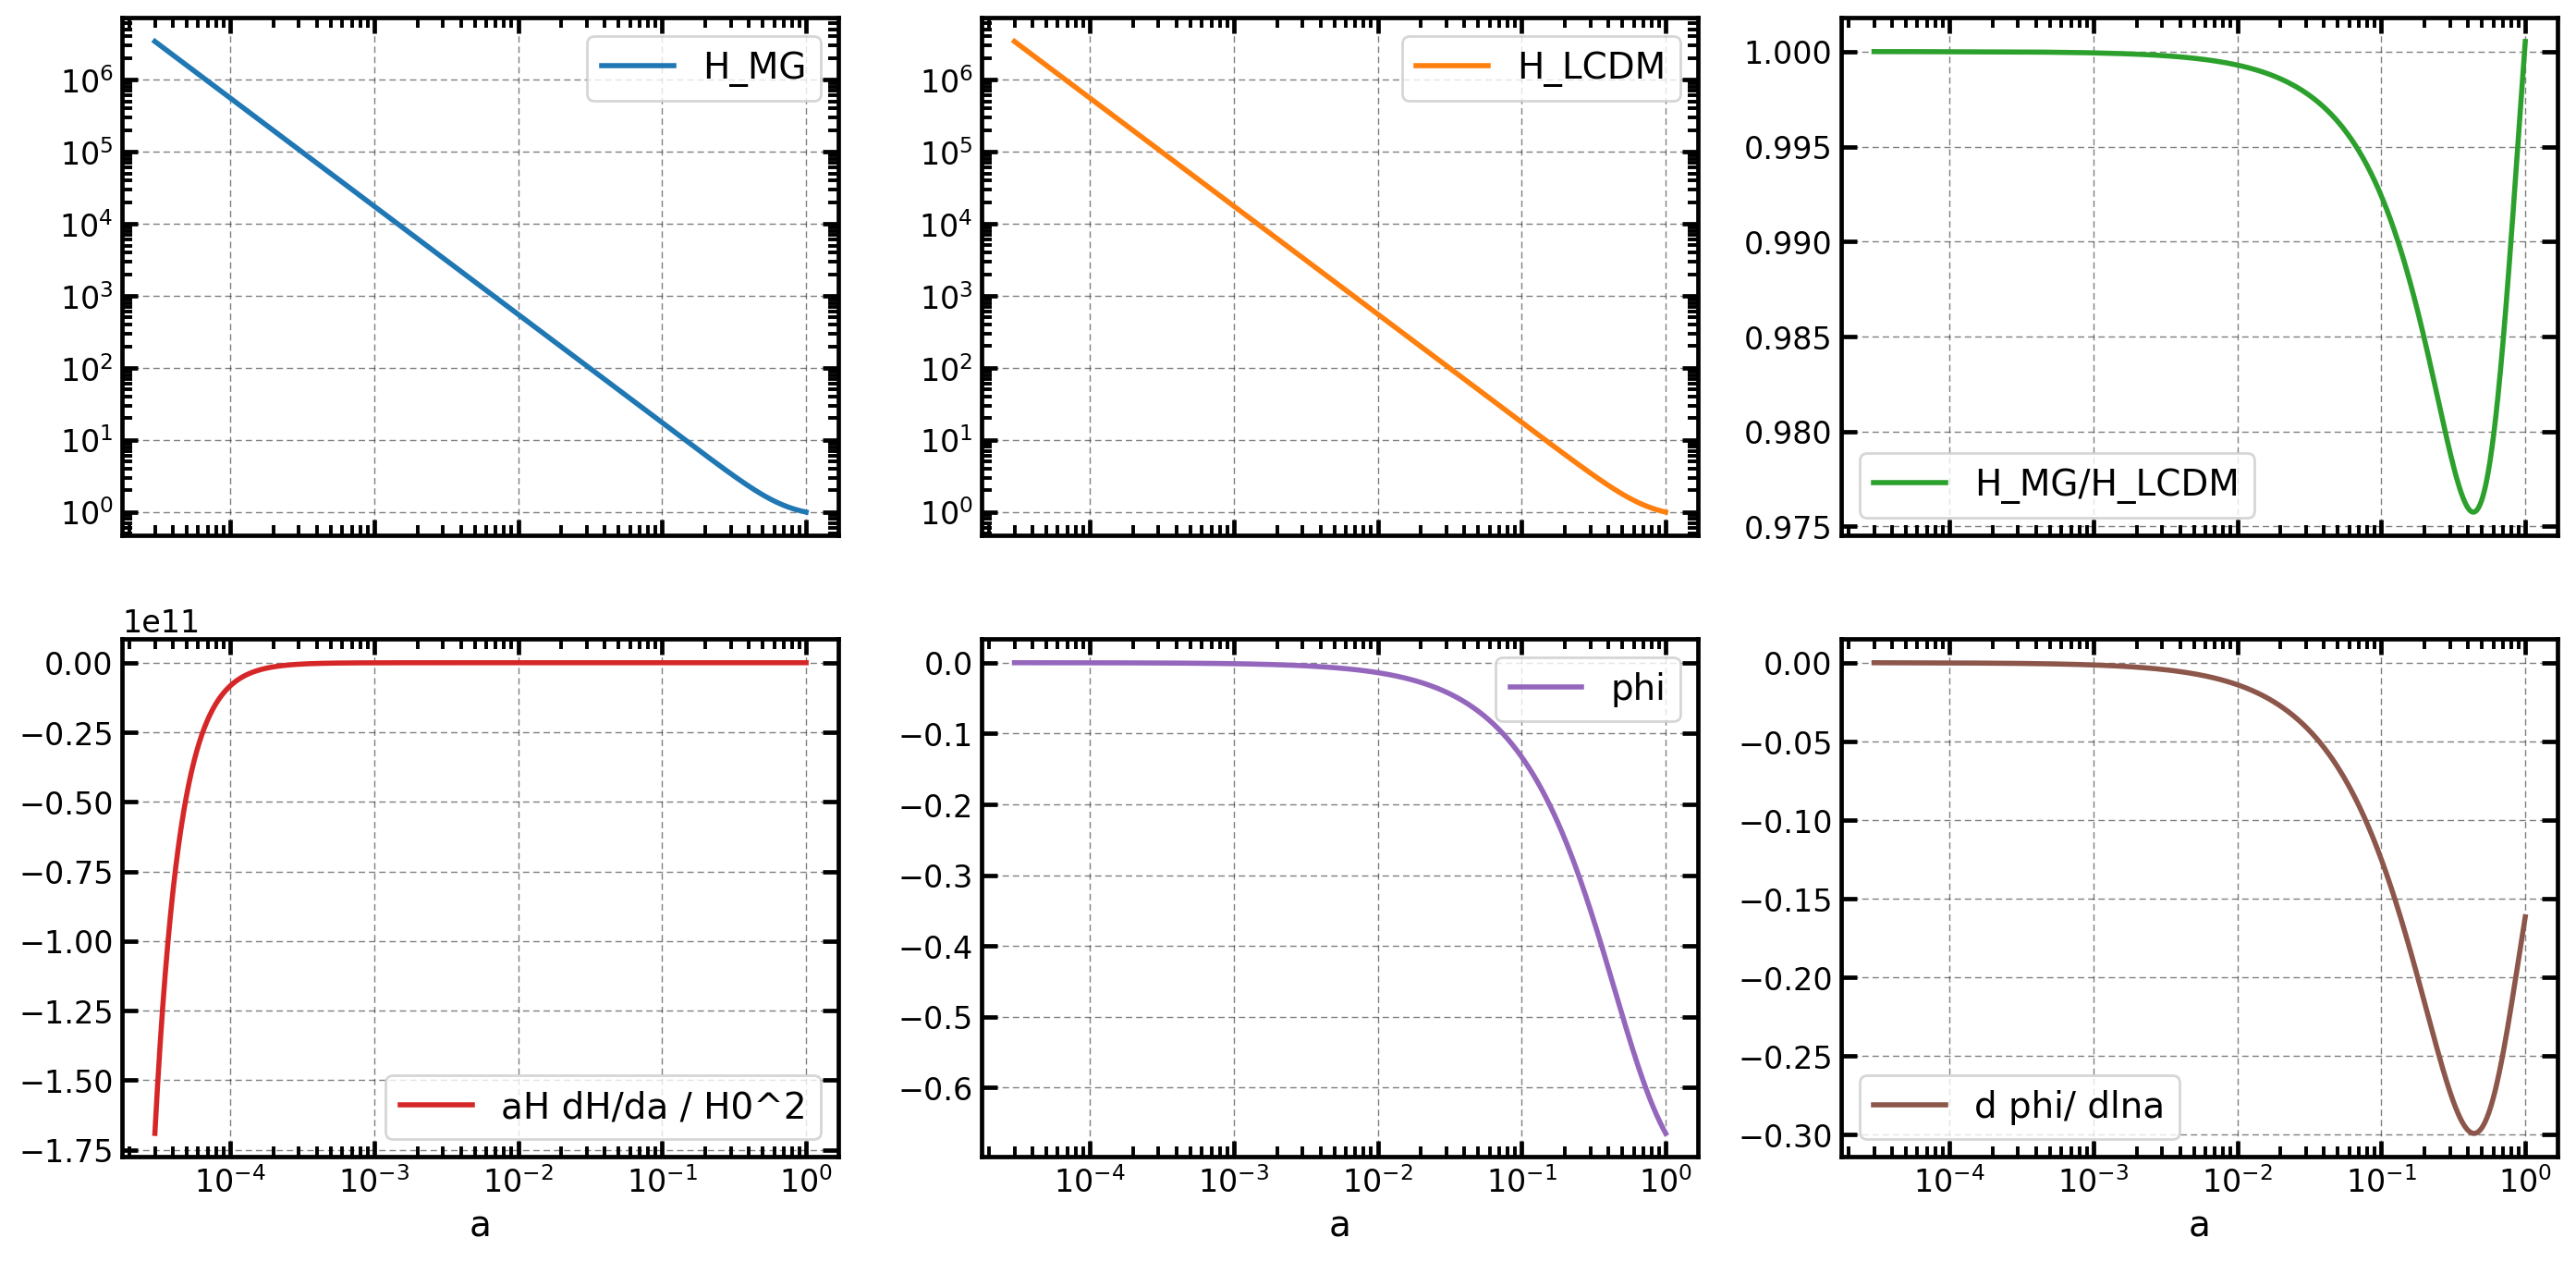

In [11]:
fig, axs = plt.subplots(2,3, figsize=(17,8), sharex=True)
df_Ben_BG.plot(ax=axs, subplots=True)

for ax in axs.flatten():
    ax.set_xscale('log')
    if (ax.get_ylim()[1]>10) and (ax.get_ylim()[0]>-1e9):
        ax.set_yscale('log')

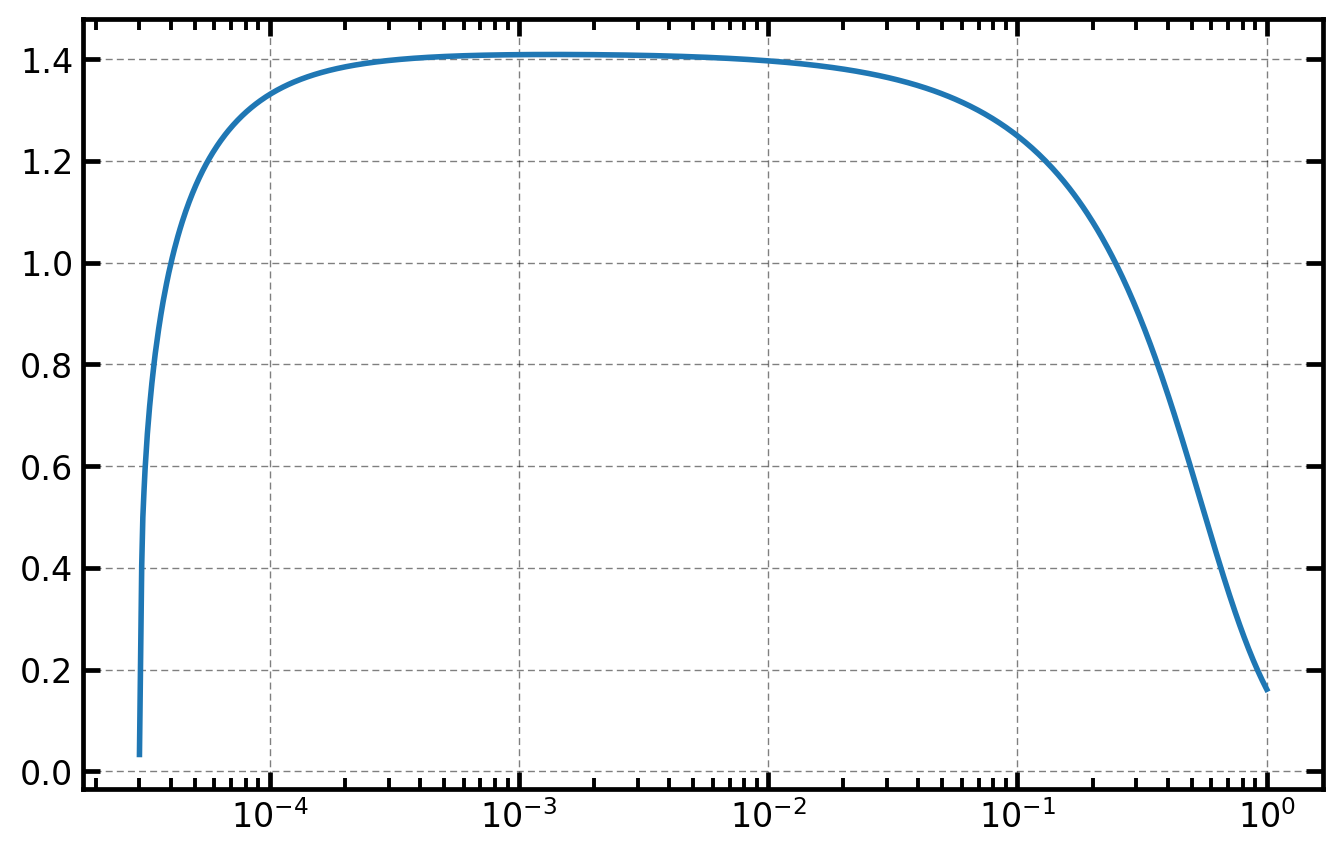

In [12]:
plt.semilogx(abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.index))

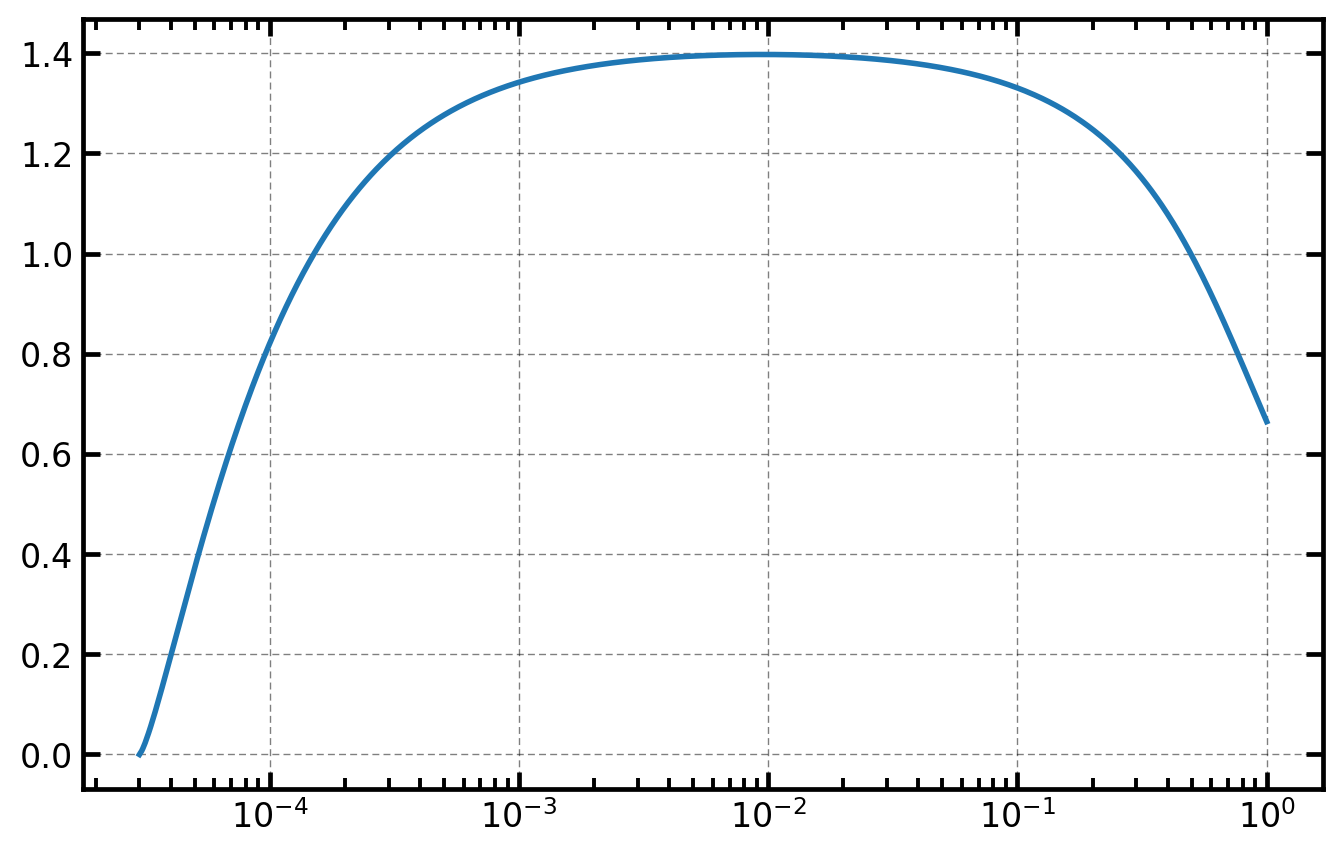

In [13]:
plt.semilogx(-(df_Ben_BG['phi']/df_Ben_BG.index))

# Expansion

In [14]:
E_vals_LCDM = lambdify((a),H_LCDM/H0_hinvMpc)(df_Ben_BG.index)

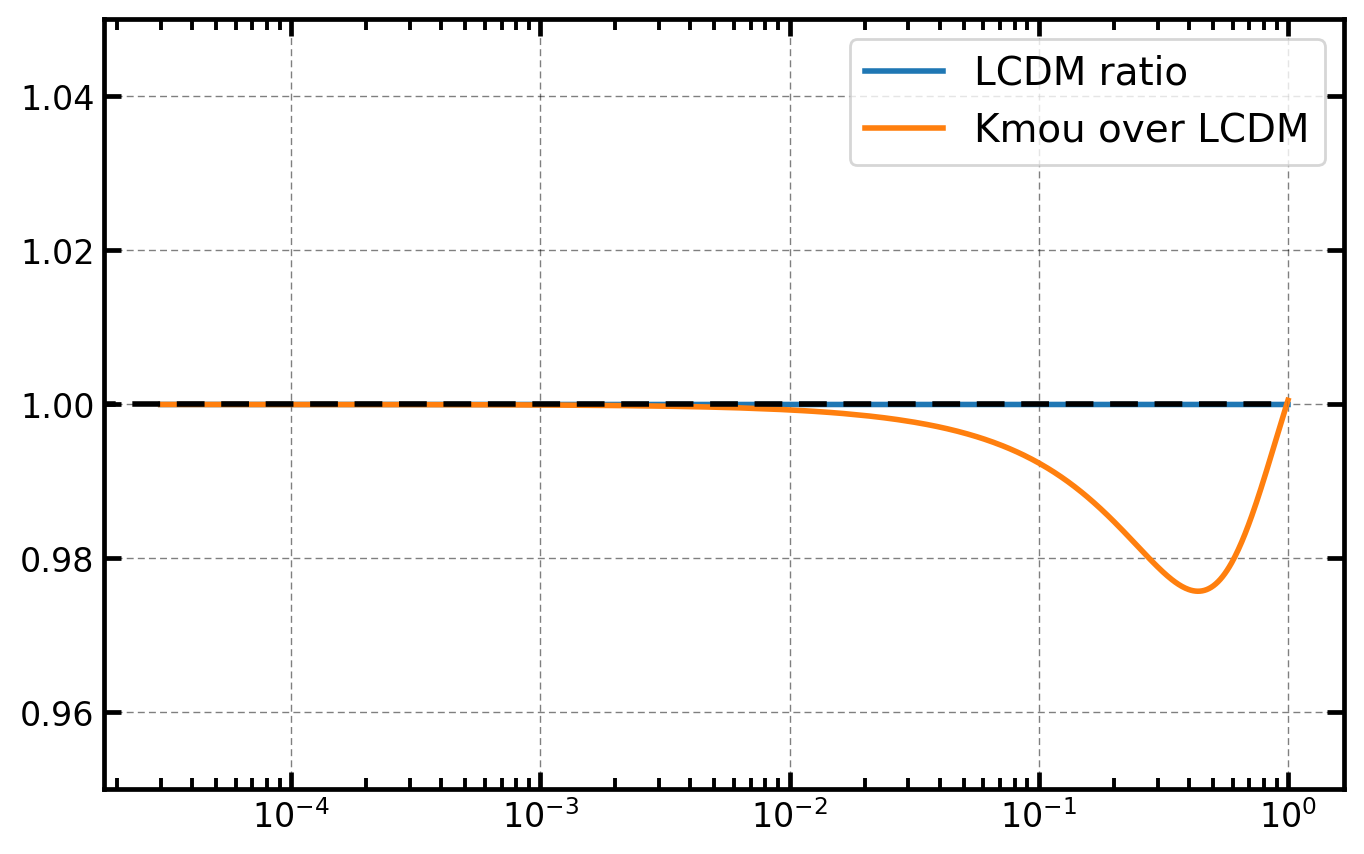

In [15]:
plt.semilogx(df_Ben_BG['H_LCDM']/E_vals_LCDM, label='LCDM ratio')
plt.semilogx(df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou over LCDM')
plt.ylim(0.95,1.05)
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.legend();

# Background

#### $k$-mouflage

The growth equation for the k-mouflage model in the Einstein frame reads:
$$D_{1}^{\prime \prime}+\left[\frac{a^{\prime}}{a}+\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi} \varphi^{\prime}\right] D_{1}^{\prime}-4 \pi G \bar{\rho}_{\mathrm{m}}(a) a^2 A(\bar{\varphi})\left[1+\frac{2 \beta_{\mathrm{Kmo}}^2}{K_X(\bar{X})}\right] D_{1}=0$$
where the conformal factor is given by 
$$A(\varphi)= \exp \left(\beta_{\mathrm{Kmo}} \varphi\right),$$
$$\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi}=\beta_{\mathrm{Kmo}}.$$
Here we focus on the model:
$$K(X)=-1+X+K_0 X^n$$
with $n=2$ and $K_0=1$. Furthermore, we fix $\beta_{\mathrm{Kmo}}=0.2$. Hence, we have 
$$A(\varphi)=\exp \left(0.2 \varphi\right),$$
$$K_X(\bar{X}) = 1 + 2\bar{X} = 1 + \frac{\bar{\varphi}^{\prime 2}}{\lambda^2 a^2 H_0^2}.$$
where $\lambda=1.476$ is necessary to recover the correct value of $H_0$ today.

In [16]:
symbols(r'\phi, \phi^{\prime}, \phi^{\prime\prime}, X')

In [17]:
# Define kmouflage quantities
beta = 0.2
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
A = exp(beta*phi)
rho_m = Om*3*H0_hinvMpc**2/(8*pi*G) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf
phi_p_ofa = a*H_conf*phi.diff(a)
phi_pp_ofa = a*H_conf*(phi_p_ofa).diff(a)

n=2
K0=1
lamb= symbols(r'\lambda')
K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

# mu_kmou = 1+ 2*beta**2/(K_x_bar)

We use that:
- $\rho_m = 3 \Omega_m H_0^2 /(8 \pi G)$
- $\frac{d}{dt} = \frac{d}{a d\tau}$
- $\dot{\phi} = \phi^{\prime}/a$
- $\ddot{\phi} = \frac{d}{dt}(\phi^{\prime}/a) = \frac{1}{a^2}\phi^{\prime\prime} - \frac{1}{a^2} \phi^{\prime} \mathcal{H}$

and as above:
$$\frac{d}{d\tau} = a \mathcal{H} \frac{d}{da}$$

# Test solver

We first construct a solver that uses 3 variables:
- $\phi$
- $\phi_a \equiv \frac{d \phi}{d a}$
- $E_a \equiv \frac{d E}{d a}$

We compare its solutions to Ben's.

In [18]:
# test increasing precision
import mpmath as mp
mp.dps = 15
mp.prec = 53

In [19]:
# lamb =1.476
lamb_val = nsimplify(5)
lamb =symbols(r'\lambda')
beta=0.2 
n=3 
K0=1
H0_target=1
a_ini=3e-4
a_fin=2

In [20]:
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
# symbols for system of diff eq
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = (Om*H0_hinvMpc**2/(8*pi*G/3))#.evalf(30) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

kmou_back = ((K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m).evalf(n=30, subs={Om0:Om0_val})
H_kmou_sq = rho_m/3*8*pi*G*A+(K_x*phi_d**2/3 - lamb**2*K*H0_hinvMpc**2/3) -H**2
# E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1]#.subs(phi.diff(a),phi_a)
E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1]#/N(sqrt(2)))*sqrt(2)

In [21]:
# ---------------------------- READ ----------------------------
# The chosen equation to compute the derivative E' has an effect on the solution
E_kmou_a_eq = (((-4*pi*G*A*rho_m - K_x*phi_d**2/2 - lamb**2*H0_hinvMpc**2*K)/3-H**2)/H_conf/H0_hinvMpc).evalf(n=30, subs={Om0:Om0_val})
# E_kmou_a_eq = E_kmou.diff(a)#
# E_kmou_a_eq = E_kmou_a_eq.subs(E, E_kmou)
# H_LCDM = H0_hinvMpc*sqrt(Om+Ol)
# E_kmou_a_eq = (H_LCDM/H0_hinvMpc).diff(a)

In [22]:
# kmou_back = kmou_back.subs(X, X_bar)
# E_kmou_a_eq = E_kmou_a_eq.subs(X, X_bar).expand()

dphia_o_da_sym_eq = solve(kmou_back.subs(phi.diff(a),phi_a),Derivative(phi_a,a))[0]
# ---------------------------- READ ----------------------------
# Substuting E_kmou inside dphia_o_da_sym_eq produces a different results than using the integrated E
# dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).subs(E, E_kmou).subs(phi.diff(a),phi_a)
dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).subs(phi.diff(a),phi_a)

In [23]:
# dphia_o_da_sym_eq = solve(kmou_back.subs(E.diff(a),E_kmou_a_eq).subs(phi.diff(a),phi_a), Derivative(phi_a,a))[0]
dH_o_da_sym_eq = E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a)

In [24]:
dphi_o_da_eq = lambdify((a, phi, phi_a, E), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a, E), dphia_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}),
                        modules='mpmath')
dE_o_da_eq = lambdify((a, phi, phi_a, E), dH_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}),
                     modules='mpmath')


def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1], vec[2]),
            dphia_o_da_eq(t,vec[0],vec[1], vec[2]),
           dE_o_da_eq(t,vec[0],vec[1], vec[2]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-0.1*a_ini, -1, H_LCDM.subs(a,a_ini)/H0_hinvMpc),
                       dense_output=True, rtol=1e-9,
                       method='LSODA',
                       atol=1e-9
                      )

In [25]:
E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[4]

In [26]:
E_kmou_sq_fun = lambdify((a, phi, phi_a, E), nsimplify(H_kmou_sq+H**2).subs(X,X_bar).subs(lamb,lamb_val).subs(Derivative(phi, a), phi_a)/H0_hinvMpc**2)
E_kmou_fun = lambdify((a, phi, phi_a), nsimplify(E_kmou).subs(lamb,lamb_val).subs(Derivative(phi, a), phi_a))
E_kmou_a_fun = lambdify((a, phi, phi_a), nsimplify(E_kmou_a_eq).subs(lamb,lamb_val).subs(Derivative(phi, a), phi_a))

In [27]:
a_vals = np.linspace(1e-4, 1, 100)
phi_vals = np.logspace(-20, 1, 100)

In [28]:
E_3p55_sq = np.array([E_kmou_sq_fun(t,f,f_p, E)**(1/2)
                   for t,f,f_p, E in zip(H_kmou_sol['t'], *H_kmou_sol['y'])]) 


In [29]:
E_3p55 = np.array([E_kmou_fun(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p55_Ben = np.array([E_kmou_fun(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

<lambdifygenerated-6>:2: RuntimeWarning: invalid value encountered in sqrt
  return -10943416811677/15625000000*sqrt(Dummy_510**6*a**2*sqrt((33935546875/864)/Dummy_510**12 + (723984375/256)*exp((1/5)*_Dummy_509)/(Dummy_510**12*a**3) + (429386445/8192)*exp((2/5)*_Dummy_509)/(Dummy_510**12*a**6) - (244140625/12)/(Dummy_510**14*a**2) + (244140625/2)/(Dummy_510**16*a**4) - 244140625/(Dummy_510**18*a**6))/((193899122102869/1000000000)*Dummy_510**6*a**4*(sqrt((33935546875/864)/Dummy_510**12 + (723984375/256)*exp((1/5)*_Dummy_509)/(Dummy_510**12*a**3) + (429386445/8192)*exp((2/5)*_Dummy_509)/(Dummy_510**12*a**6) - (244140625/12)/(Dummy_510**14*a**2) + (244140625/2)/(Dummy_510**16*a**4) - 244140625/(Dummy_510**18*a**6)) + (395284707521047/64000000000)/Dummy_510**6 + (73262067691951/320000000000)*exp((1/5)*_Dummy_509)/(Dummy_510**6*a**3))**(2/3) + (335843131025171/1000000000)*1j*Dummy_510**6*a**4*(sqrt((33935546875/864)/Dummy_510**12 + (723984375/256)*exp((1/5)*_Dummy_509)/(Dummy_510**12*a**3) 

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_19605/4047214952.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')
/Users/bartolomeo/miniconda3/envs/pyoperon/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bartolomeo/miniconda3/envs/pyoperon/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


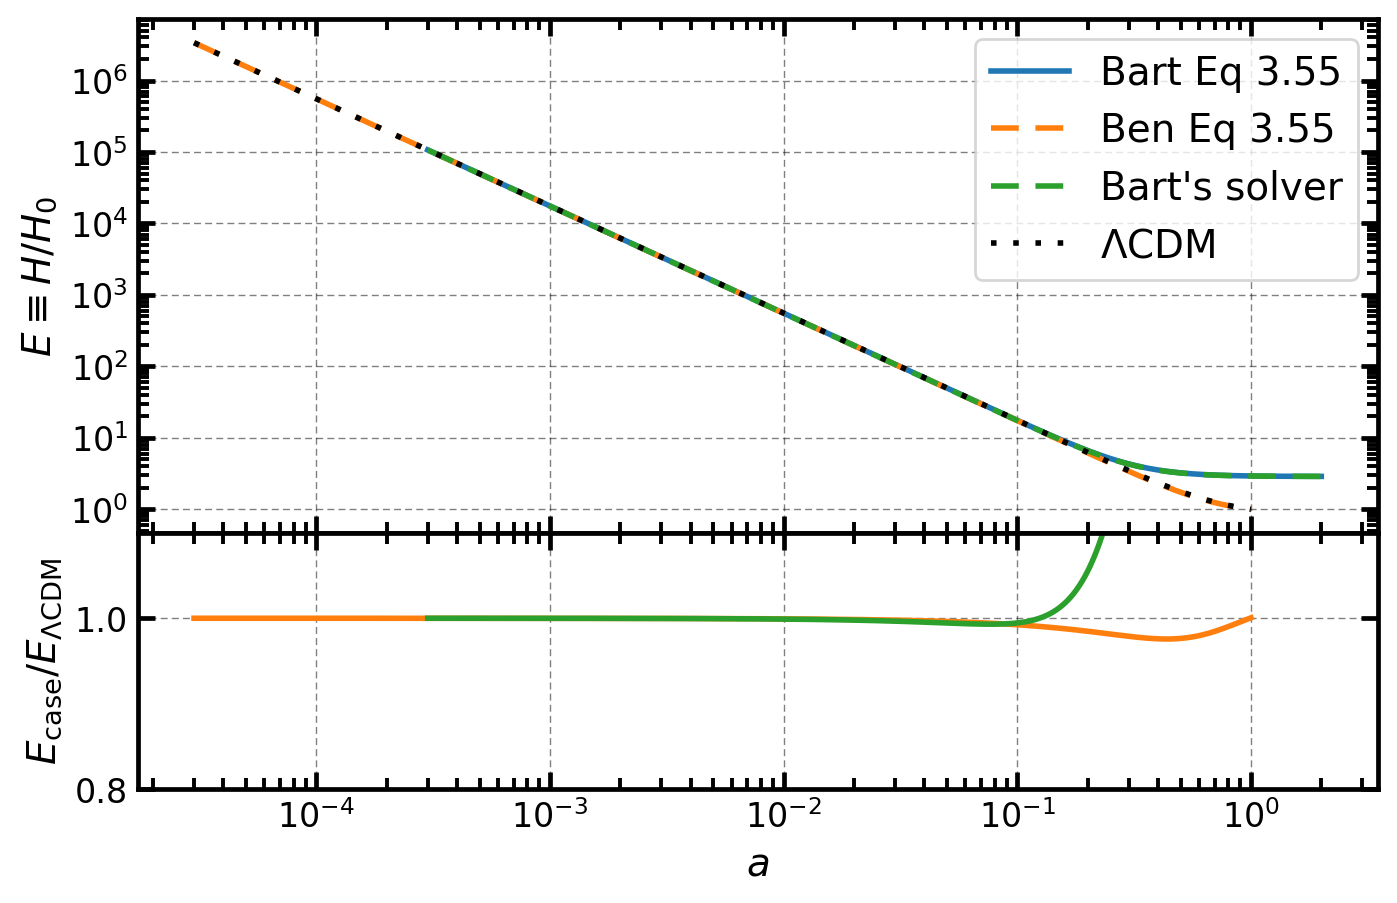

In [30]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], E_3p55_sq, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, df_Ben_BG['H_MG'], '--', label='Ben Eq 3.55' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), '--',label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, df_Ben_BG['H_MG']/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, label='Ben Eq 3.55' )
axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

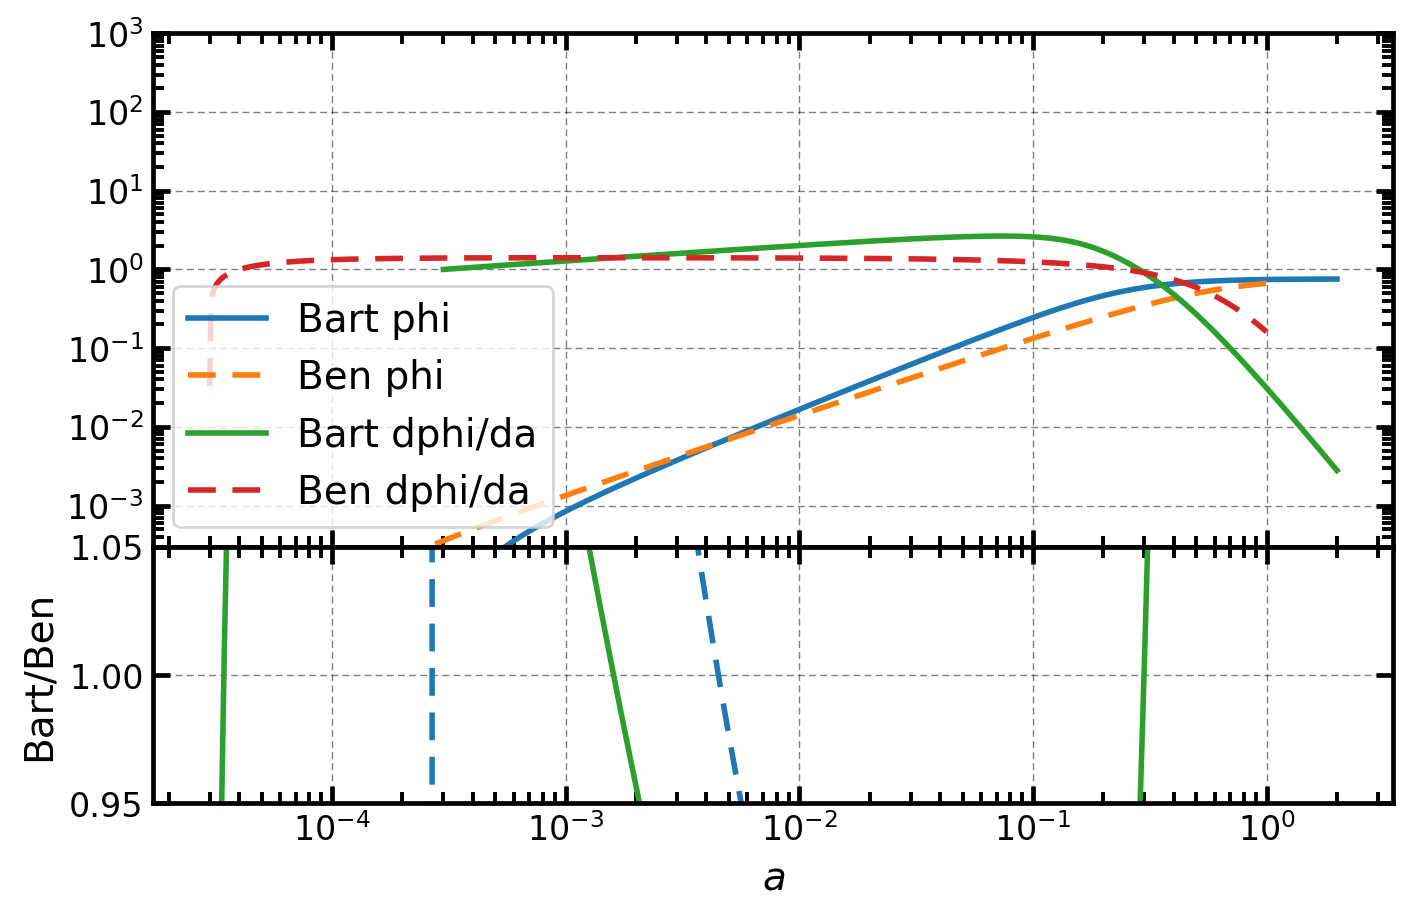

In [31]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][0]), label='Bart phi')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['phi']), '--',label='Ben phi' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][1]), label='Bart dphi/da')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.index), '--',label='Ben dphi/da' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,1000)
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index, 'C2')
axs[1].plot((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0], '--C0' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

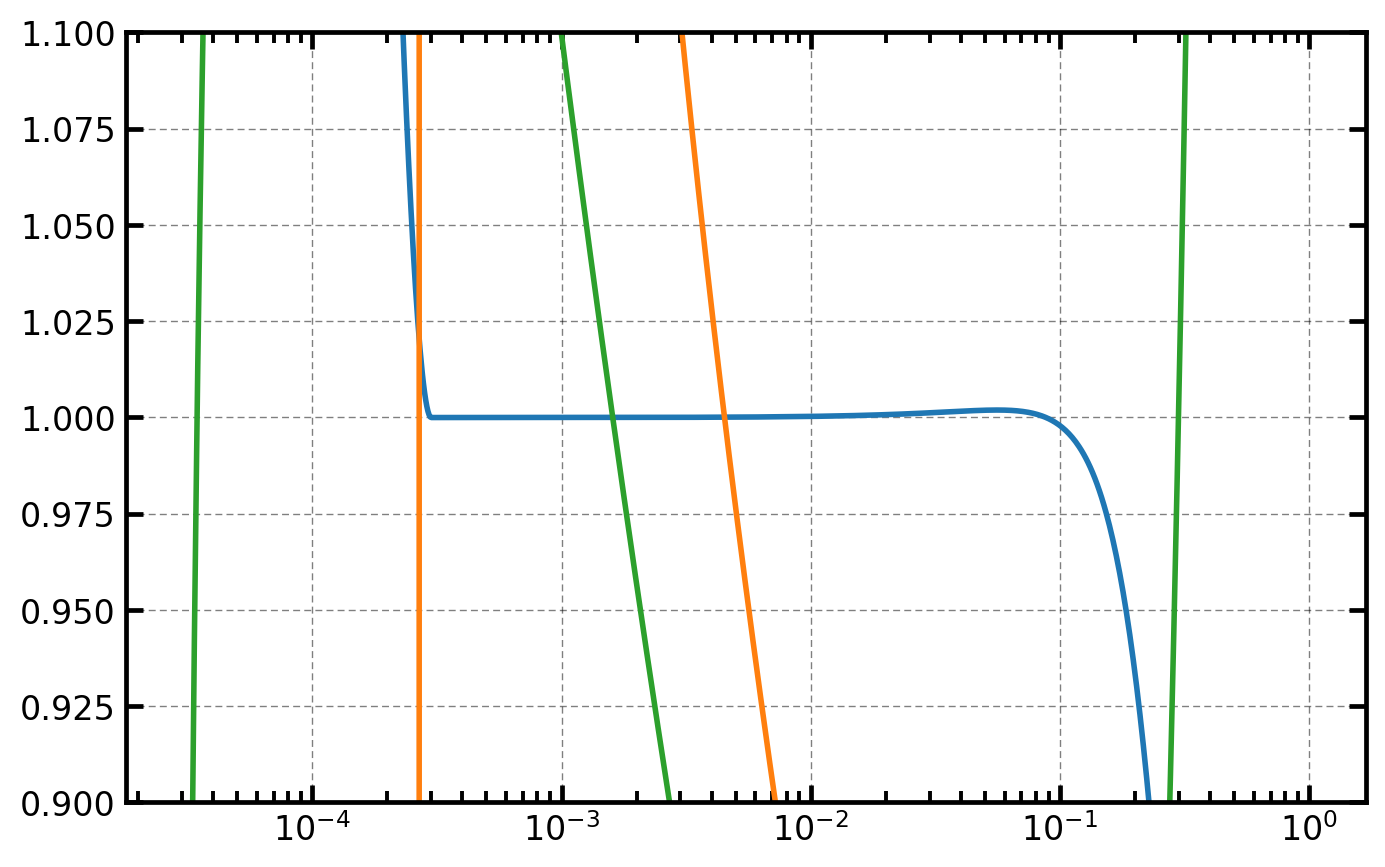

In [32]:
# plt.loglog(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]))
plt.semilogx(abs(df_Ben_BG['H_MG'])/H_kmou_sol.sol(df_Ben_BG.index)[2])
plt.semilogx((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0])
plt.semilogx((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index)
plt.ylim(0.9,1.1)

# Export solver

In [101]:
from scipy.optimize import fsolve

In [303]:
def solve_Kmou_expansion(lamb=1, beta=0.2, n=2, K0=1, mode='search', H0_target=1, a_ini=3e-5, a_fin=1, a_vals=None):
    phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
    phi = Function(r'\phi')(a)
    phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
    # symbols for system of diff eq
    phi_a = symbols(r'\phi_a')

    phi_p = a*H_conf*phi.diff(a)
    phi_pp = a*H_conf*(phi_p).diff(a)

    A = exp(beta*phi)
    rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
    phi_d = phi_p/a
    phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

    K = (-1 + X + K0*X**n)
    K_x = K.diff(X)
    K_xx = K_x.diff(X)
    X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
    K_x_bar = K_x.subs(X, X_bar)
    K_xx_bar = K_xx.subs(X, X_bar)

    kmou_back = (K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m
    E_kmou_a_eq = ((1/3*(-4*pi*G*A*rho_m - K_x*phi_d**2/2 - lamb**2*H0_hinvMpc**2*K) - H**2)/H_conf/H0_hinvMpc).expand()
    H_kmou_sq = (8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2).subs(X, X_bar).subs(phi.diff(a),phi_a)

    kmou_back = kmou_back.subs(X, X_bar).subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).expand().subs(phi.diff(a),phi_a)

    dphia_o_da_sym_eq = solve(kmou_back, Derivative(phi_a,a))[0]
    dE_o_da_sym_eq = E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a)

    dphi_o_da_eq = lambdify((a, phi, phi_a, E), phi_a)
    dphia_o_da_eq = lambdify((a, phi, phi_a, E), dphia_o_da_sym_eq.simplify())
    dE_o_da_eq = lambdify((a, phi, phi_a, E), dE_o_da_sym_eq.simplify())

    H_kmou_sq_fun = lambdify((a, phi, phi_a, E), H_kmou_sq)

    def dum_fun(t,vec):
        '''Dummy function to adapt the input of solve_ivp'''
        dummer_fun = lambda E: H_kmou_sq_fun(t,*vec[:2],E)
        E_val = fsolve(dummer_fun, vec[2])[0]
        return (dphi_o_da_eq(t,*vec[:2],E_val),
                dphia_o_da_eq(t,*vec[:2],E_val),
               dE_o_da_eq(t,*vec[:2],E_val))

    # Compute the solution of the differential equation
    H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-0.1*a_ini, -0.01, H_LCDM.subs(a,a_ini)/H0_hinvMpc), 
                            dense_output=True, 
                           rtol=1e-9,atol=1e-9,
                              # method='LSODA'
                          )
    if mode=='search':
        dummer_fun = lambda E: H_kmou_sq_fun(1,*H_kmou_sol.sol(1)[:2],E)
        E_val = fsolve(dummer_fun, H_kmou_sol.sol(1)[2])[0]
        return np.array(E_val - H0_target)/H0_target
    elif mode=='phi':
        return H_kmou_sol
    elif mode=='full':
        E_vals =[]
        if a_vals is None:
            a_vals = H_kmou_sol.t
        for a_ in a_vals:
            dummer_fun = lambda E: H_kmou_sq_fun(a_,*H_kmou_sol.sol(a_)[:2],E)
            E_vals.append(fsolve(dummer_fun, H_kmou_sol.sol(a_)[2])[0])
        E_vals = np.array(E_vals)
        E_kmou_a_fun =lambdify((a, phi, phi_a, E), E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a))
        return H_kmou_sol, E_vals, E_kmou_a_fun(a_vals, *H_kmou_sol.sol(a_vals)[:2], E_vals)

In [283]:
from scipy.optimize import newton

In [388]:
a_ini=3e-5
beta= 0.2
k0 = 1
n=5
best_lamb = newton(lambda l: solve_Kmou_expansion(l, a_ini=a_ini, beta=beta, K0=K0, n=n), 1.476, maxiter=10)

/Users/bartolomeo/miniconda3/envs/pyoperon/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/bartolomeo/miniconda3/envs/pyoperon/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [389]:
best_lamb

In [390]:
# H_kmou_sol, E_kmou_a_fun = solve_Kmou_expansion(1.476, beta=beta, K0=K0, n=n, mode='full')
H_kmou_sol, E_kmou_anal, E_kmou_a = solve_Kmou_expansion(best_lamb, beta=beta, K0=K0, n=n, mode='full')

/Users/bartolomeo/miniconda3/envs/pyoperon/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/bartolomeo/miniconda3/envs/pyoperon/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [391]:
E_3p55 = E_kmou_anal

E_3p55_Ben = np.array([E_kmou_fun(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

<lambdifygenerated-6>:2: RuntimeWarning: invalid value encountered in sqrt
  return -10943416811677/15625000000*sqrt(Dummy_510**6*a**2*sqrt((33935546875/864)/Dummy_510**12 + (723984375/256)*exp((1/5)*_Dummy_509)/(Dummy_510**12*a**3) + (429386445/8192)*exp((2/5)*_Dummy_509)/(Dummy_510**12*a**6) - (244140625/12)/(Dummy_510**14*a**2) + (244140625/2)/(Dummy_510**16*a**4) - 244140625/(Dummy_510**18*a**6))/((193899122102869/1000000000)*Dummy_510**6*a**4*(sqrt((33935546875/864)/Dummy_510**12 + (723984375/256)*exp((1/5)*_Dummy_509)/(Dummy_510**12*a**3) + (429386445/8192)*exp((2/5)*_Dummy_509)/(Dummy_510**12*a**6) - (244140625/12)/(Dummy_510**14*a**2) + (244140625/2)/(Dummy_510**16*a**4) - 244140625/(Dummy_510**18*a**6)) + (395284707521047/64000000000)/Dummy_510**6 + (73262067691951/320000000000)*exp((1/5)*_Dummy_509)/(Dummy_510**6*a**3))**(2/3) + (335843131025171/1000000000)*1j*Dummy_510**6*a**4*(sqrt((33935546875/864)/Dummy_510**12 + (723984375/256)*exp((1/5)*_Dummy_509)/(Dummy_510**12*a**3) 

In [392]:
E_3p56 = np.array([E_kmou_a_fun(t,f,f_p, E) 
                   for t,f,f_p, E in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1], H_kmou_sol['y'][2])])

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_19605/2784010079.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')


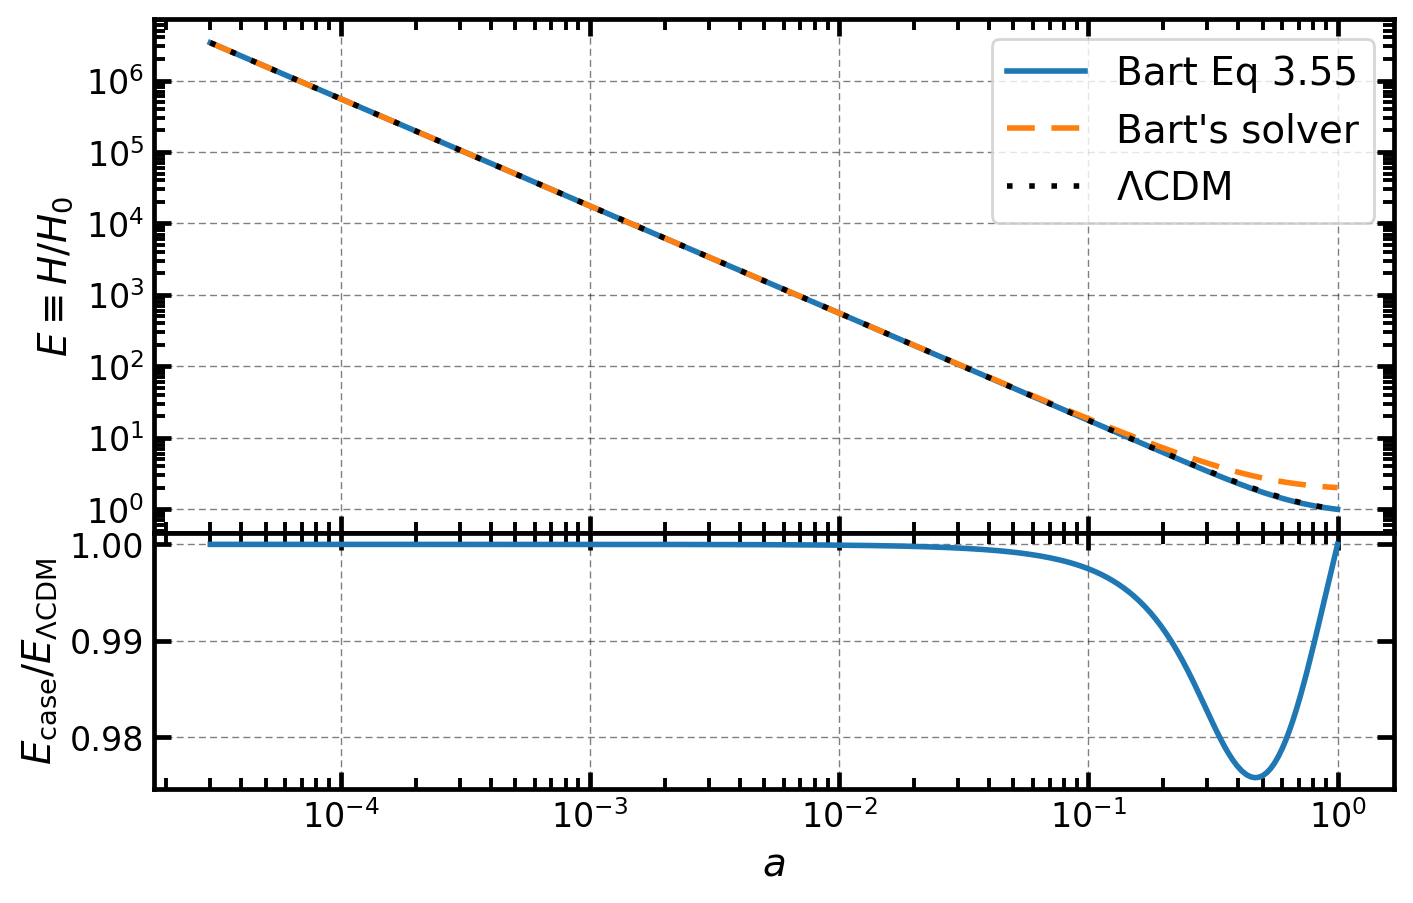

In [393]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], E_3p55, label='Bart Eq 3.55')
# axs[0].plot(df_Ben_BG.index, E_3p55_Ben, label='Ben Eq 3.55' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), '--',label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

# axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
# axs[1].plot(df_Ben_BG.index, E_3p55_Ben/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, '--',label='Ben Eq 3.55' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Integrated E")
axs[1].plot(H_kmou_sol['t'], abs(E_3p55)/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Analytical E")
# axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);
plt.savefig(f'./figures/n{n}-beta0p2-k1/Background.pdf', format='pdf')

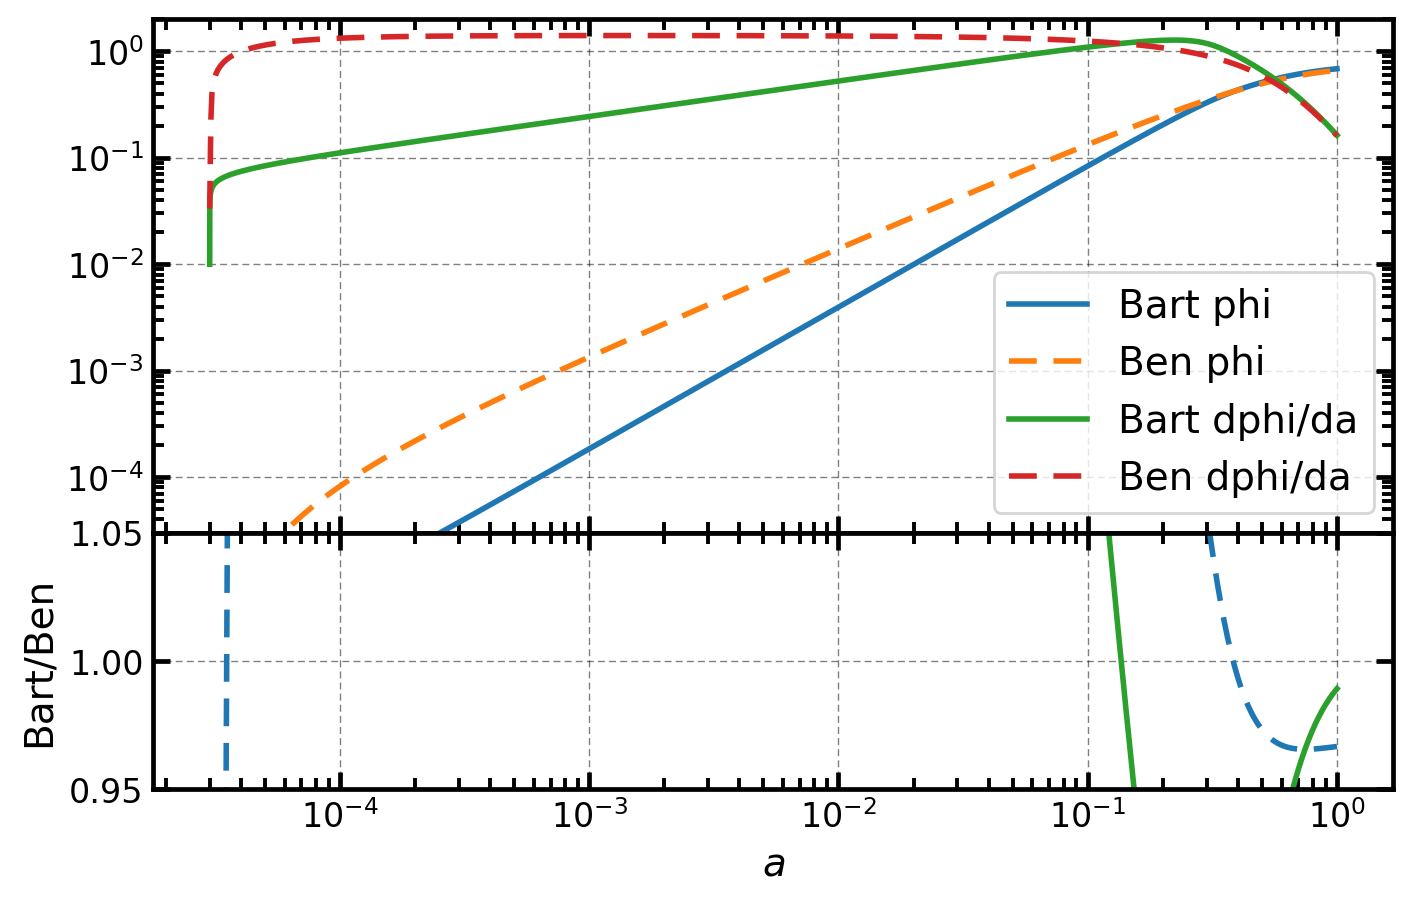

In [394]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][0]), label='Bart phi')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['phi']), '--',label='Ben phi' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][1]), label='Bart dphi/da')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.index), '--',label='Ben dphi/da' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,2)
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index, 'C2')
axs[1].plot((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0], '--C0' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

# Jordan frame

In [395]:
a_vals = H_kmou_sol['t']

phi_kmou = InterpolatedUnivariateSpline(a_vals, H_kmou_sol['y'][0])
phi_diffa_kmou = phi_kmou.derivative()
E_kmou = InterpolatedUnivariateSpline(a_vals, H_kmou_sol['y'][2])
E_diffa_kmou = E_kmou.derivative()
phi_p_kmou = lambda a: a*(a*E_kmou(a)*H0_hinvMpc)*phi_diffa_kmou(a)

#### Background

In [396]:
A_vals = np.e**(beta* H_kmou_sol['y'][0])

In [397]:
a_E_vals = H_kmou_sol['t']
a_J_vals = a_E_vals*A_vals

In [398]:
H_J = E_kmou_anal/A_vals * (1 + a_E_vals*beta*phi_diffa_kmou(a_E_vals))

In [399]:
lambdify((a),H_LCDM/H0_hinvMpc)(1)

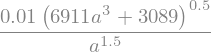

In [400]:
H_LCDM.simplify()

In [401]:
E_vals_LCDM_J = lambdify((a),H_LCDM.simplify()/H0_hinvMpc)(np.array(list(a_J_vals)))

#### Interpolate

In [402]:
phi_kmou_J = InterpolatedUnivariateSpline(a_J_vals, H_kmou_sol['y'][0], ext=3)
phi_diffa_kmou_J = phi_kmou_J.derivative()
E_kmou_J = InterpolatedUnivariateSpline(a_J_vals, H_J, ext=3)
E_diffa_kmou_J = E_kmou_J.derivative()
# E_diffa_kmou_J = lambda a: E_kmou_a_fun(a)
phi_p_kmou_J = lambda a: a*(a*E_kmou_J(a)*H0_hinvMpc)*phi_diffa_kmou_J(a)

#### Hubble Ratio

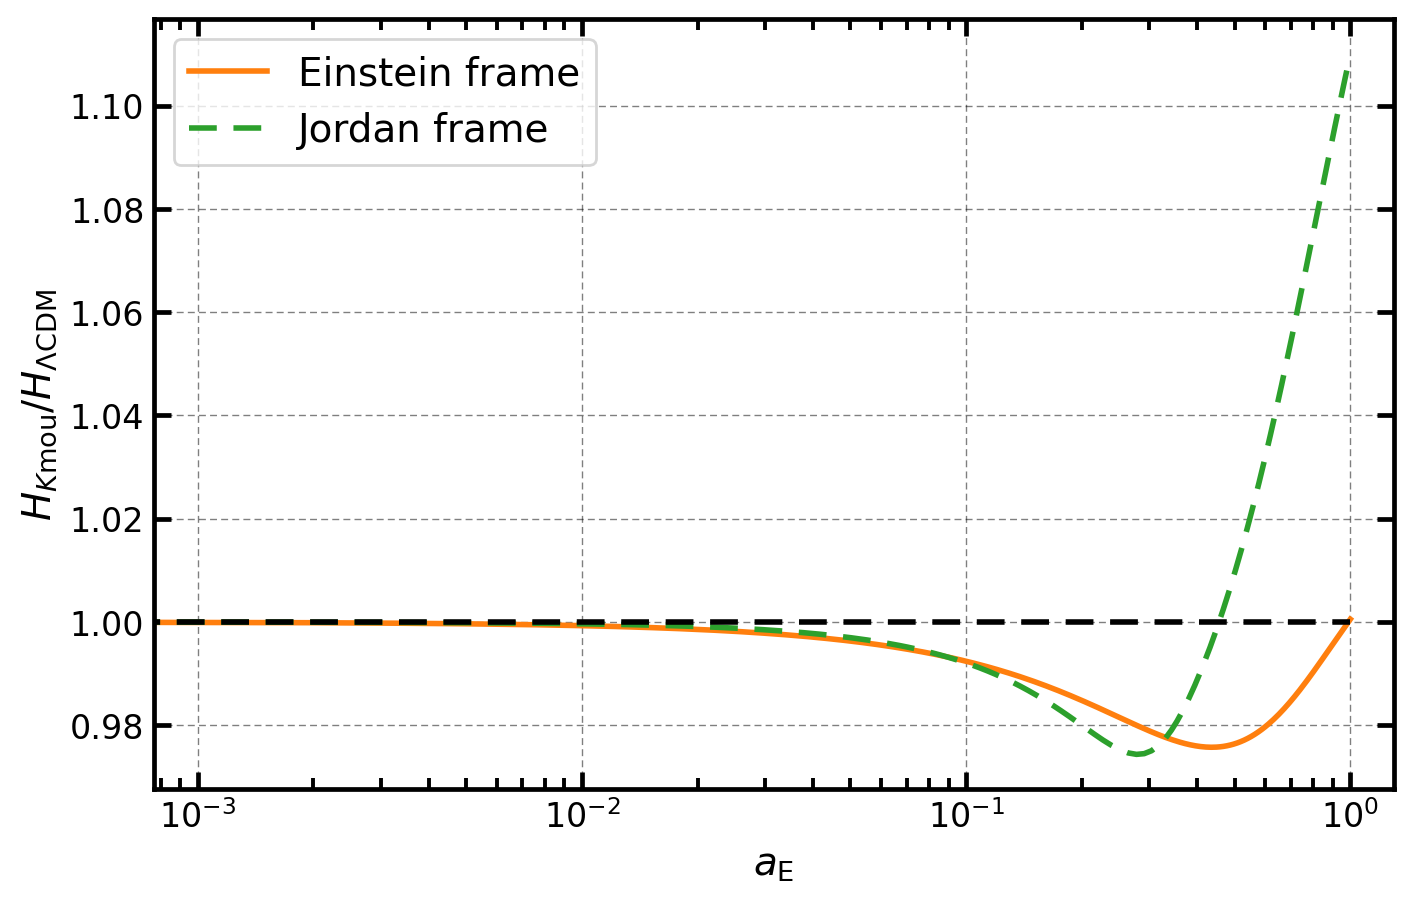

In [403]:
# plt.plot(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou-E / LCDM-E')
plt.plot( df_Ben_BG['H_MG']/E_vals_LCDM, 'C1', label='Einstein frame')
plt.plot(a_E_vals, H_J/lambdify((a),H_LCDM.simplify()/H0_hinvMpc)(np.array(list(a_E_vals))), '--C2', label='Jordan frame')
plt.xscale('log')
plt.xlim(a_min/margin, a_max*margin)
y_min, y_max = plt.ylim()
# plt.vlines(A_vals.iloc[-1], y_min, y_max, linestyles=':', colors='k')
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel(r'$H_{K{\rm mou}}/H_{\Lambda {\rm CDM}}$')
plt.legend();
plt.savefig('./figures/n2-beta0p2-k1/HubbleRateRatio.pdf', format='pdf')

#### $k$-mouflage

The growth equation for the k-mouflage model in the Jordan frame reads:
$$D_{1}'' + \mathcal{H} D_{1}' - \frac{3}{2} \, A^2 \Omega_{m} H_{0}^{2} a^{2} \mu D_{1} = 0,$$
where $\mu = 1+\epsilon_1$, $\epsilon_1 = \frac{2 \beta^2}{K_x}$ and $\Omega_{m}$ is the Einstein frame matter density, hence the presence of the $A^2$ factor to take into account the running of the Planck mass in the Jordan frame and how densities transform between the two frames.

The conformal factor is given by 
$$A(\varphi)= \exp \left(\beta_{\mathrm{Kmo}} \varphi\right),$$
$$\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi}=\beta_{\mathrm{Kmo}}.$$

We use the Einstein frame model:
$$K(X)=-1+X+K_0 X^n$$
<!-- is translated in the Jordan frame as:
$$\tilde{K}= X \tilde{k} -1 = X -1 = -1+X+K_0 X^n$$ -->

with $n=2$ and $K_0=1$. Furthermore, we fix $\beta_{\mathrm{Kmo}}=0.2$. Hence, we have 
$$A(\varphi)=\exp \left(0.2 \varphi\right),$$
$$K_X(\bar{X}) = 1 + 2\bar{X} = 1 + \frac{A^2 \bar{\varphi}^{\prime 2}}{\lambda^2 a^2 H_0^2}.$$
where $\lambda=1.476$ is necessary to recover the correct value of $H_0$ today.

In [404]:
# Define kmouflage quantities
phi, phi_p, X = symbols(r'\phi, \phi^{\prime}, X')
A = exp(beta*phi)

K = -1 + X + K0*X**n
K_x = K.diff(X)
X_bar_J = A**2*phi_p**2/(2*best_lamb**2 * a**2 * H0_hinvMpc**2)
# X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar_J = K_x.subs(X, X_bar_J)
# K_x_bar = K_x.subs(X, X_bar)

mu_kmou_J = 1 + 2*beta**2/(K_x_bar_J)
# mu_kmou = 1 + 2*beta**2/(K_x_bar)

In [405]:
# Set up differential equation
# diff_eq_kmou_j = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf)*D(a).diff(a) \
#                 -3/2*A**2*Om*(H0_hinvMpc)**2*a**(2)*mu_kmou_J*D(a)

diff_eq_kmou_j = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf)*D(a).diff(a) \
                -3/2*A**2*Om*(H0_hinvMpc)**2*a**(2)*mu_kmou_J*D(a)

# diff_eq_kmou_j = a*(a*D(a).diff(a)).diff(a) + (2+1/H**2*a*H*H.diff(a))*a*D(a).diff(a) \
#                 -3/2*Om*(H0_hinvMpc/H)**2*mu_kmou_J*D(a)

diff_eq_kmou_j = diff_eq_kmou_j.expand()

And then solve the differntial equation numerically:

In [406]:
# Split 2nd order differential equation in a system of first order differential equations
x_sym_eq = diff_eq_kmou_j.subs(D(a).diff(a),x).subs(D(a),y).subs(E.diff(a),E_diffa)

x_eq= lambdify((a,x,y,E,E_diffa,phi,phi_p), solve(x_sym_eq, Derivative(x,a))[0])
y_eq = lambdify((a,x,y), x)

In [407]:
def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (x_eq(t,vec[0],vec[1], E_kmou_J(t),E_diffa_kmou_J(t), phi_kmou_J(t), phi_p_kmou_J(t)),
            y_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
D_kmou_J = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(1,a_ini), dense_output=True, rtol=1e-9)

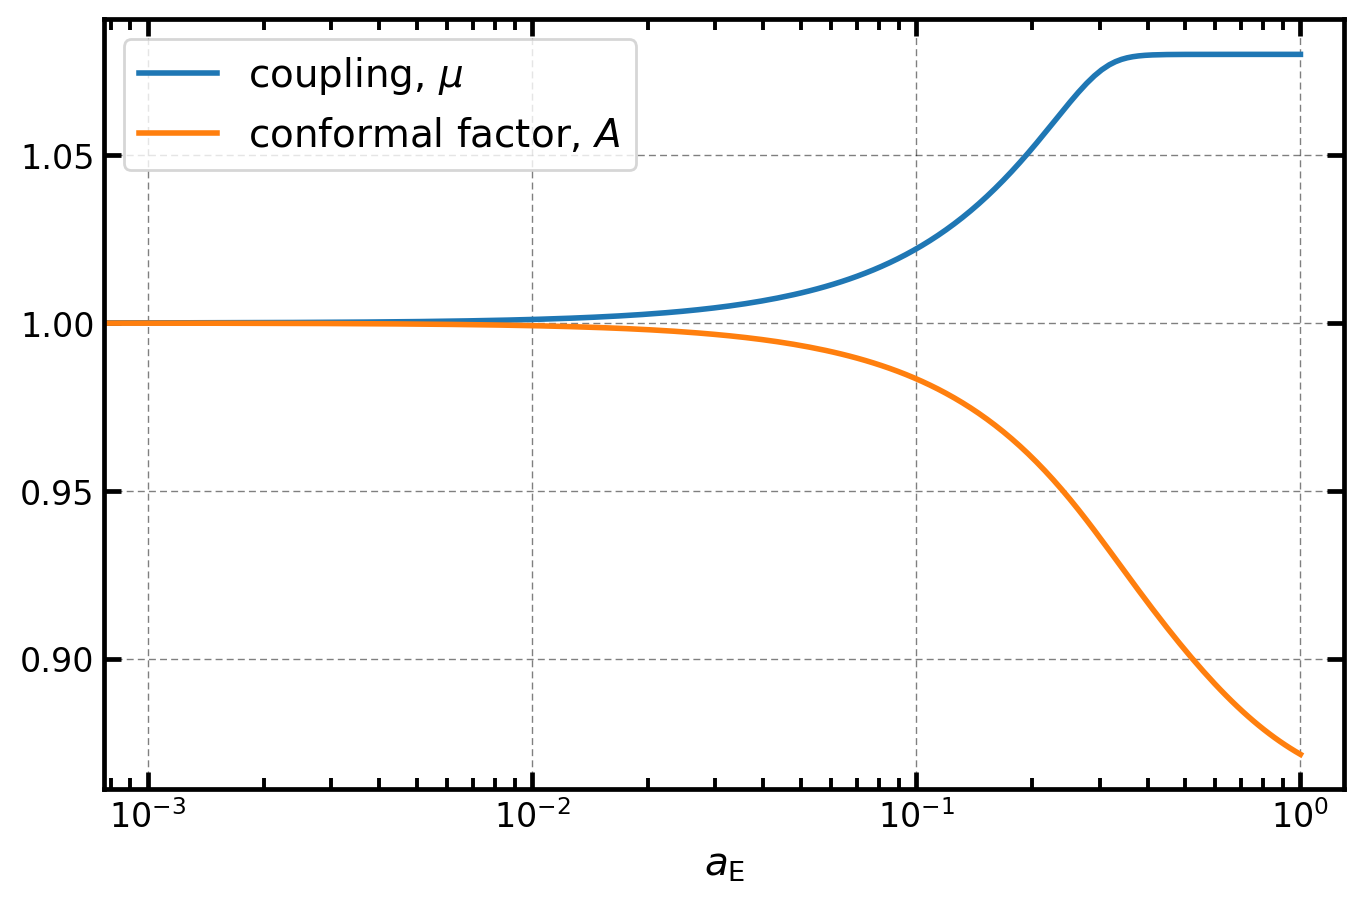

In [408]:
plt.semilogx(a_E_vals, lambdify([a, phi, phi_p], mu_kmou_J)(a_J_vals,
                                                              phi_kmou_J(a_J_vals),
                                                              phi_p_kmou_J(a_J_vals)), 
             label=r'coupling, $\mu$')

plt.semilogx(a_E_vals, lambdify([phi], A)(phi_kmou(a_E_vals)), label=r'conformal factor, $A$')

plt.xlabel(r'$a_{\rm E}$')

plt.legend()
plt.xlim(a_min/margin, a_max*margin)
plt.savefig(f'./figures/n{n}-beta0p2-k1/MG-effects.pdf', format='pdf')

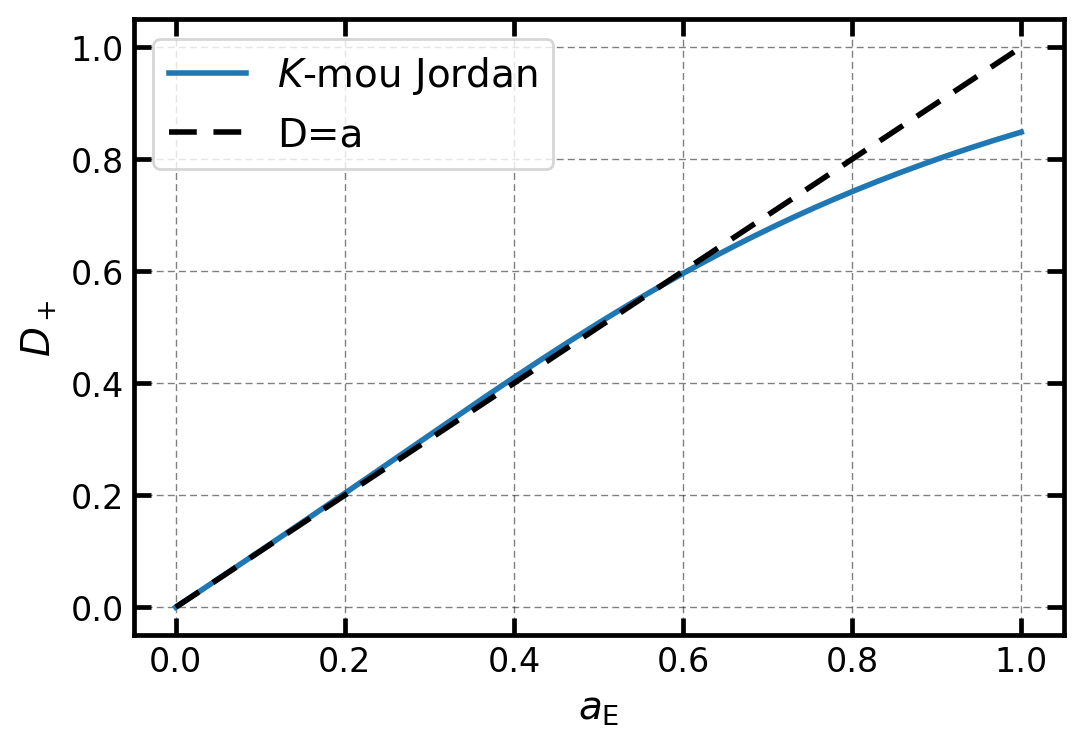

In [409]:
plt.figure(figsize=(6,4))
plt.plot(a_E_vals, D_kmou_J.sol(a_J_vals)[1],label='$K$-mou Jordan')
plt.plot(a_E_vals , a_E_vals, 'k--', label='D=a')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel('$D_+$');
plt.legend();
plt.savefig(f'./figures/n{n}-beta0p2-k1/Growth_comp.pdf', format='pdf')

# Output

In [410]:
out_table = np.array([a_E_vals, a_J_vals, E_kmou_J(a_J_vals), E_diffa_kmou_J(a_J_vals), 
                      phi_kmou_J(a_J_vals), phi_p_kmou_J(a_J_vals),
                      lambdify([a, phi, phi_p], mu_kmou_J)(a_J_vals, phi_kmou_J(a_J_vals),
                                                                        phi_p_kmou_J(a_J_vals)),
                     A_vals, D_kmou_J.sol(a_J_vals)[1]]).T

header = 'a_E, a_J, E_J, dE_J/da, phi_J, dphi_J/dtau, G_eff/G, A_conf, D_kmou'
header =''.join([i.ljust(16) for i in header.split(', ')])

np.savetxt(f'./Data/Output/n{n}-beta0p2-k1/out_table.txt', out_table, header=header, fmt='%.6e', delimiter='\t')